<a href="https://colab.research.google.com/github/xdderekchen/ML/blob/master/Test_API_IXINBUY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Demonstation of Web API of ixinbuy.com

ixinbuy.com provides Web API for users to access the powerful block-chain based services.

This post has 2 purposes:
 1. Samples for API calls
 2. Testing of API and the webservice

## 1.1. Version 1

In this version, we will test the following 3 functions
 * **(POST)** http://ixinbuy.com/register
 * **(POST)** http://ixinbuy.com/uploaddata
 * **(GET)**  http://ixinbuy.com/getshareddata

### register

In [1]:
# http://ixinbuy.com/register

import requests
import json

URL = "http://ixinbuy.com/register"

DEVICE_ID = "XD_COVID19_V3"

payload = {"device_id":DEVICE_ID}

#Passing payload as dict
responce = requests.post(URL, data = payload)
print(responce.status_code)
print(responce.text)


#Passing payload as json string
#payload = '{"device_id":"XD12345"}'
#responce = requests.post(URL, json = json.loads(payload))
#print(responce.status_code)
#print(responce.text)

500
{"message":"Endorsement has failed","stack":"Error: Endorsement has failed\n    at DiscoveryEndorsementHandler._endorse (/home/uadmin/fabric-samples/medicalnet/fabric_api/node_modules/fabric-client/lib/impl/DiscoveryEndorsementHandler.js:185:19)","endorsements":[{"message":"transaction returned with failure: Error: This key already exists: XD_COVID19_V3","stack":"Error: transaction returned with failure: Error: This key already exists: XD_COVID19_V3\n    at self._endorserClient.processProposal (/home/uadmin/fabric-samples/medicalnet/fabric_api/node_modules/fabric-client/lib/Peer.js:144:36)\n    at Object.onReceiveStatus (/home/uadmin/fabric-samples/medicalnet/fabric_api/node_modules/grpc/src/client_interceptors.js:1207:9)\n    at InterceptingListener._callNext (/home/uadmin/fabric-samples/medicalnet/fabric_api/node_modules/grpc/src/client_interceptors.js:568:42)\n    at InterceptingListener.onReceiveStatus (/home/uadmin/fabric-samples/medicalnet/fabric_api/node_modules/grpc/src/cli

### uploaddata (single)

In [14]:
# http://ixinbuy.com/uploaddata

import requests
import json

URL = "http://ixinbuy.com/uploaddata"

# data_type": 2 for COVID19 data
payload = {
   "data_type": 2, 
   "device_id": DEVICE_ID,
   "device_data": {
          "date": "2019-01-08",
          "province_state": "Shanghai02",
          "country_region": "Mainland China",
          "last_update": "2019-01-07T10:43:02",
          
          "confirmed":100,
          "deaths": 7,
          "recovered": 1237,
          "latitude":  23.3417,
          "longitude": 113.4244,
          "key": "date|country_region|province_state"
   }
}


#Passing payload as dict
responce = requests.post(URL, json = payload)
print(responce.status_code)
print(responce.text)


200
true


### get data

In [16]:
import pandas as pd 
import os 
import requests 
import json

query = {"data_type": 2, "device_id":DEVICE_ID, "from_date": "2019-01-07"}

req = requests.get('http://ixinbuy.com/getshareddata', params=query) 
print(req.url) 
print(req.status_code) 
print(req) 
data = req.json()

df = pd.DataFrame(data)
df

http://ixinbuy.com/getshareddata?data_type=2&device_id=XD_COVID19_V3&from_date=2019-01-07
200
<Response [200]>


,date,province_state,country_region,last_update,confirmed,deaths,recovered,latitude,longitude,key,county
0,2019-01-07,Shanghai00,Mainland China,2019-01-07T10:43:02,100,7,1237,23.3417,113.4244,date|country_region|province_state,NaN
1,2019-01-07,Shanghai00,Mainland China,2019-01-07T10:43:02,100,7,1237,23.3417,113.4244,date|country_region|province_state|county,test
2,2019-01-07,Shanghai02,Mainland China,2019-01-07T10:43:02,100,7,1237,23.3417,113.4244,date|country_region|province_state,NaN
3,2019-01-08,Shanghai02,Mainland China,2019-01-07T10:43:02,100,7,1237,23.3417,113.4244,date|country_region|province_state,NaN


### Define a function to rename the columns with standard names.

In [17]:
import numpy as np
import pandas as pd
import os 

def transform_names(df):
    '''
       need to have standard names
    '''
    df.columns = [x.lower() for x in df.columns]
    df.rename(columns={'province/state': 'province_state',
                   'admin2'            : 'county',
                   'country/region'    : 'country_region',
                   'last update'       : 'last_update',
                   "long_":          "longitude",
                   "long":          "longitude",
                   "lat":           "latitude",
                   "lat_":           "latitude",
                  }, inplace=True)
    if ("county" in df.columns):
       df["key"] = "date|country_region|province_state|county"
    else:
       df["key"] = "date|country_region|province_state"
    
    return (df)

##### Testing
def run_test(date= "03-20-2020"):
    github_root = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports"
    file = os.path.join(github_root, date + ".csv")
    df = pd.read_csv(file ,dtype = {'FIPS': str, 'ZIP': str, "ZIP_CODE": str})
    df = transform_names(df)
    print(df.columns)

    row = df.iloc[1]
    print(json.loads(row.to_json()))

run_test("03-20-2020")  #Old format
run_test("03-26-2020")  #new format


Index(['province_state', 'country_region', 'last_update', 'confirmed',
       'deaths', 'recovered', 'latitude', 'longitude', 'key'],
      dtype='object')
{'province_state': None, 'country_region': 'Italy', 'last_update': '2020-03-20T17:43:03', 'confirmed': 47021, 'deaths': 4032, 'recovered': 4440, 'latitude': 41.8719, 'longitude': 12.5674, 'key': 'date|country_region|province_state'}
Index(['fips', 'county', 'province_state', 'country_region', 'last_update',
       'latitude', 'longitude', 'confirmed', 'deaths', 'recovered', 'active',
       'combined_key', 'key'],
      dtype='object')
{'fips': '22001', 'county': 'Acadia', 'province_state': 'Louisiana', 'country_region': 'US', 'last_update': '2020-03-26 23:48:35', 'latitude': 30.2950649, 'longitude': -92.41419698, 'confirmed': 3, 'deaths': 0, 'recovered': 0, 'active': 0, 'combined_key': 'Acadia, Louisiana, US', 'key': 'date|country_region|province_state|county'}


### uploaddata (batch)

In here, we will pull real data from John Hopkins and invoke the webservice call.

The data of John Hopkins is at "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports"
    

In [18]:
import pandas as pd
import numpy as np
import os
import requests
import json

def uploaddata(source_file, URL, data_date):
    print("processing: ", source_file)
    df = pd.read_csv(source_file, dtype = {'FIPS': str, 'ZIP': str, "ZIP_CODE": str})
    df = transform_names(df)
    errorCount = 0
    for i in range(0, df.shape[0])  :####df.itertuples(index=False):
      
        row = df.iloc[i]
        #row_as_dic = row.to_dict()
       
        device_data = {"date":data_date }
        device_data.update(json.loads(row.to_json()))
       
        payload = {
           "data_type": 2, 
           "device_id": DEVICE_ID,
           "device_data": device_data
        }

        #print(payload)
        #if row["country_region"] == "US":
        responce = requests.post(URL, json = payload)
      
        
        if (responce.status_code == 200) and ( responce.text == "true"):
           if (i % 10==0):
              print(i, "", end='', flush=True)
        else:
              errorCount += 1
              print("\nError ", i , " with ", responce.text, flush=True)

    print(f"\nProcessed {i+3} of records")
    return (errorCount)
      
       

github_root = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports"


file = os.path.join(github_root, "03-26-2020" + ".csv")

import time
ts = time.time()
d = uploaddata(file, "http://ixinbuy.com/uploaddata", "2020-03-26")
te = time.time()
print('%s  %2.2f sec' % ("uploaddata", (te - ts) ))
 


processing:  https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/03-26-2020.csv
0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 600 610 620 630 640 650 660 670 680 690 700 710 720 730 740 750 760 770 780 790 800 810 820 830 840 850 860 870 880 890 900 910 920 930 940 950 960 970 980 990 1000 1010 1020 1030 1040 1050 1060 1070 1080 1090 1100 1110 1120 1130 1140 1150 1160 1170 1180 1190 1200 1210 1220 1230 1240 1250 1260 1270 1280 1290 1300 1310 1320 1330 1340 1350 1360 1370 1380 1390 1400 1410 1420 1430 1440 1450 1460 1470 1480 1490 1500 1510 1520 1530 1540 1550 1560 1570 1580 1590 1600 1610 1620 1630 1640 1650 1660 1670 1680 1690 1700 1710 1720 1730 1740 1750 1760 1770 1780 1790 1800 1810 1820 1830 1840 1850 1860 1870 1880 1890 1900 1910 1920 1930 1

### getshareddata (GET)

This is the method to retrieve data from server



In [39]:
import pandas as pd
import os
import requests
import json

def get_sample_data(df, num_sample):
   df_agg=df.groupby(["country_region", "date"]).agg({'confirmed': ['sum'], 'deaths': ['sum'], 'recovered': ['sum']})
   df_agg.columns = ['confirmed', 'deaths', 'recovered']
   df_agg.reset_index(inplace=True)
   df_agg["fatality_rate"] = df_agg["deaths"] / df_agg["confirmed"]
   df_confirm = df_agg.sort_values(by='confirmed', ascending=False)
   return (df_confirm.head(num_sample))
   

query = {"data_type": 2, "device_id":DEVICE_ID, "from_date": "2020-03-20"}

req = requests.get('http://ixinbuy.com/getshareddata', params=query)
print(req.url)
print(req.status_code)

df_confirm_20 = pd.DataFrame()

if (req.status_code == 200):
  data = req.json()
  if len(data): 
     df = pd.DataFrame(data)
     df_confirm_20 = get_sample_data(df, 20)
    
df_confirm_20



http://ixinbuy.com/getshareddata?data_type=2&device_id=XD_COVID19_V3&from_date=2020-03-20
200


,country_region,date,confirmed,deaths,recovered,fatality_rate
163,US,2020-03-26,83836,1209,681,0.014421
33,China,2020-03-26,81782,3291,74181,0.040241
81,Italy,2020-03-26,80589,8215,10361,0.101937
148,Spain,2020-03-26,57786,4365,7015,0.075537
62,Germany,2020-03-26,43938,267,5673,0.006077
58,France,2020-03-26,29523,1698,4949,0.057514
77,Iran,2020-03-26,29406,2234,10457,0.075971
153,Switzerland,2020-03-26,11811,191,131,0.016171
167,United Kingdom,2020-03-26,11797,580,148,0.049165
87,"Korea, South",2020-03-26,9241,131,4144,0.014176


### visualization

Text(0.5, 1.0, 'Fatality Rate, for top 20 countries by the number of confirmed cases')

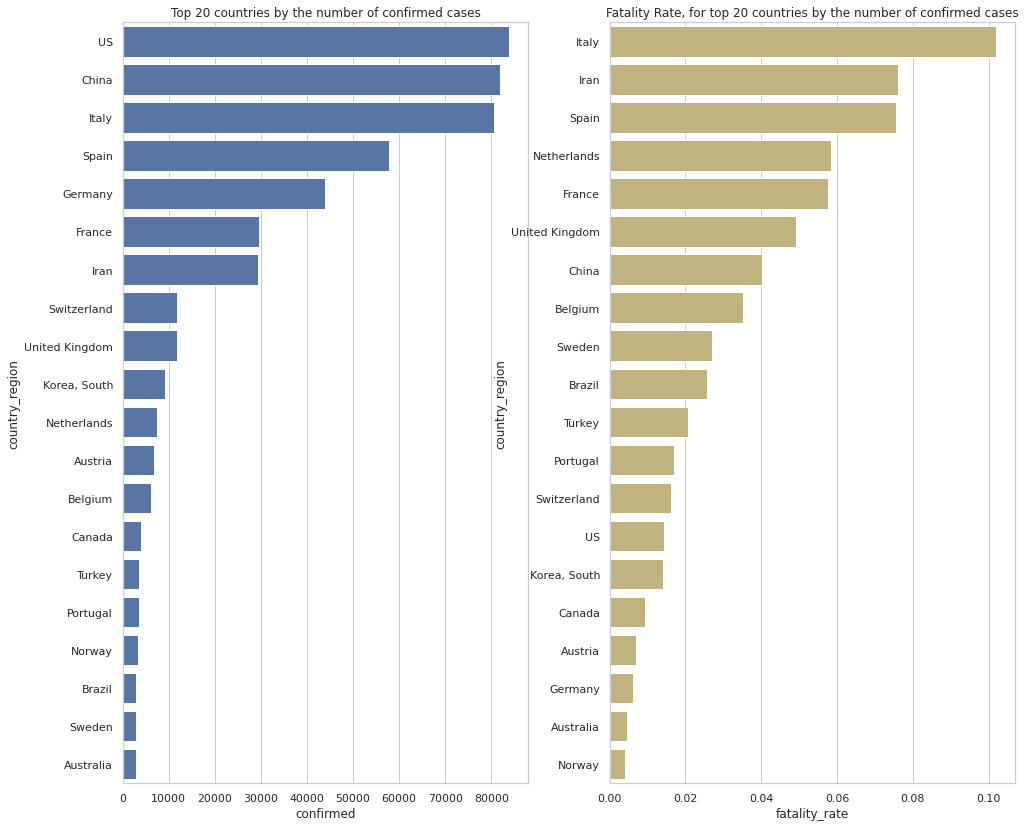

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

df_fatal_rate = df_confirm_20.sort_values(by='fatality_rate', ascending=False)

# Initialize the matplotlib figure
f, (ax1, ax2) = plt.subplots(figsize=(16, 14), ncols=2)


sns.barplot(x="confirmed", y="country_region", data=df_confirm,
            label="confirmed", color="b",  ax=ax1)
ax1.set_title("Top 20 countries by the number of confirmed cases")

sns.barplot(x="fatality_rate", y="country_region", data=df_fatal_rate,
            label="fatality rate", color="y",  ax=ax2)
ax2.set_title("Fatality Rate, for top 20 countries by the number of confirmed cases")

In [23]:
import plotly.express as px

df['province_state'] = df['province_state'].fillna(df['country_region'])
fig = px.scatter_mapbox(data_frame=df, lat="latitude", lon="longitude", hover_data=["confirmed", "deaths"],  
                        size="confirmed", zoom=2, height=1000, hover_name="province_state" )
fig.update_layout(mapbox_style="open-street-map")
fig.show()